<a href="https://colab.research.google.com/github/gpdsec/Transfer-Learning/blob/main/FoodClassification101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-889b888f-4bc4-5623-d0cf-192077a774ff)


# Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Softmax, Input, GlobalAveragePooling2D
from tensorflow.keras import mixed_precision, Sequential, layers, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import datetime
%load_ext tensorboard

# Loading Data from TFDS

In [3]:
(train_ds, test_ds), info = tfds.load('food101',
                                      split=['train', 'validation'],
                                      with_info=True,
                                      as_supervised=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [5]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [6]:
classLabels = info.features["label"].names

In [7]:
classLabels[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [8]:
for image, label in train_ds.take(1):
  break

image dtype <dtype: 'uint8'>
raw image shape (512, 512, 3)
tf.Tensor(
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]

 [[228 254 253]
  [226 255 253]
  [223 255 252]
  ...
  [164 159 155]
  [145 141 138]
  [128 127 125]]

 ...

 [[ 66 112 164]
  [ 67 113 163]
  [ 55  99 148]
  ...
  [  5  14  23]
  [  9  18  27]
  [  8  17  26]]

 [[ 76 123 177]
  [ 75 122 176]
  [ 70 116 168]
  ...
  [  5  14  23]
  [  9  18  25]
  [  7  16  23]]

 [[ 80 129 185]
  [ 71 121 174]
  [ 74 121 175]
  ...
  [  7  16  25]
  [ 11  20  27]
  [ 10  19  26]]], shape=(512, 512, 3), dtype=uint8)
image


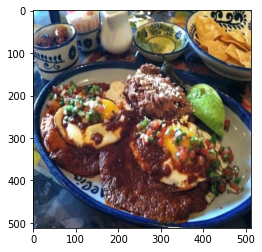

In [9]:
print(f"image dtype {image.dtype}")
print(f"raw image shape {image.shape}")
print(image)
print("image")
plt.imshow(image)

# Helpfull functions

In [10]:


# Data augmentation layer
augmentation=Sequential([
                         #tf.keras.layers.InputLayer(),
                         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                         layers.experimental.preprocessing.RandomRotation(0.2),])

# augment function
def augment(image_batch, label_batch):
  #image_batch = preprocessing.Rescaling(1./255)(image_batch)
  image_batch = augmentation(image_batch, training=True)
  
  return image_batch, label_batch

# Map Funtion
def map_funct(image, label):
  
  image = tf.image.resize_with_pad(image, 224, 224)
  #image = tf.cast(image, tf.float32)
  image = tf.image.convert_image_dtype(image, tf.float32)
  
  return image, label

# Data Pipeline

In [11]:
# Important variables
batch_size = 32
shape = (224, 224, 3)

In [12]:
# Train DataSet
train_dataset = train_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Test Dataset
test_dataset = test_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

image shape (224, 224, 3)
image dtype <dtype: 'float32'>
image [[[223.33002  230.19714  247.795   ]
  [219.17857  222.64302  242.59517 ]
  [213.46394  212.57718  231.47275 ]
  ...
  [177.29282  194.81679  194.77852 ]
  [179.95699  196.40923  199.22006 ]
  [183.16386  199.99855  205.1738  ]]

 [[225.38237  231.63377  247.771   ]
  [221.78687  224.70946  242.36655 ]
  [217.64789  216.35863  233.15538 ]
  ...
  [180.35999  199.25034  202.21152 ]
  [182.79874  200.56056  205.19992 ]
  [186.59953  204.62766  210.64983 ]]

 [[229.30121  234.7555   248.51726 ]
  [225.38457  227.77426  241.95131 ]
  [221.82228  221.07088  235.0706  ]
  ...
  [184.28003  203.37173  208.07292 ]
  [186.85748  205.25046  211.19896 ]
  [189.19487  208.16864  216.63162 ]]

 ...

 [[234.41052  241.78455  248.31914 ]
  [232.49619  242.4999   249.29788 ]
  [230.13718  240.45514  248.15497 ]
  ...
  [131.29988  127.16772  109.480644]
  [127.34837  123.26646  108.57926 ]
  [132.17178  129.29822  113.344215]]

 [[234.9718

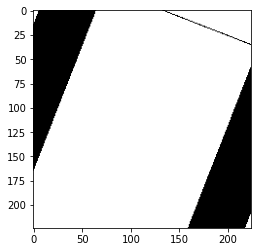

In [13]:
for images, labels in train_dataset.take(1):
  for image in images:
    print(f"image shape {image.shape}")
    print(f"image dtype {image.dtype}")
    print(f"image {image}")
    plt.imshow(image)
    break

# Setting Callback

In [14]:
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')
filepath='/content/drive/MyDrive/model/food101.h5'
md = ModelCheckpoint(filepath, monitor='val_loss', 
verbose=1, save_best_only=True, save_weights_only=False, mode='min')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch):
  lr = 0.0002
  if epoch < 10:
    return 0.0002
  else:
    return 0.0001 * tf.math.exp(-0.1)

lrs = LearningRateScheduler(scheduler)

sgd = SGD(learning_rate=0.01)
adam = Adam(learning_rate=0.0001)

# functions for custom training loop

# optimizer to train the model.
optimizer = tf.keras.optimizers.Adam()
# loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(labels, logits)
    return loss_value


@tf.function
def test_step(images, labels):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(labels, val_logits)

# Buildind Model

In [15]:
# Turn on mixed precision training
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

In [16]:
# seting up base model
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet")
base_model.trainable = False
# building model architecture

input = Input(shape=shape, name="input")
#x = preprocessing.Rescaling(1./255)(i)
x = tf.keras.applications.resnet.preprocess_input(input)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="pooling")(x)
x = Dense(101)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="predictions")(x) 
model = Model(input, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
pooling (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               206949    
_________________________________________________________________
predictions (Activation)     (None, 101)               0     

In [17]:
rm -rf ./logs

In [18]:
model_history = model.fit(train_dataset,
                            epochs=16,  
                            verbose=1, 
                            callbacks=[tb, md, es],
                            steps_per_epoch=len(train_dataset), 
                            validation_data=test_dataset, 
                            validation_steps=(0.2*len(test_dataset)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/16
2368/2368 [==============================] - 586s 233ms/step - loss: 3.0962 - accuracy: 0.2951 - val_loss: 2.0730 - val_accuracy: 0.4891

Epoch 00001: val_loss improved from inf to 2.07298, saving model to /content/drive/MyDrive/model/food101.h5
Epoch 2/16
2368/2368 [==============================] - 531s 223ms/step - loss: 2.2105 - accuracy: 0.4660 - val_loss: 1.7494 - val_accuracy: 0.5589

Epoch 00002: val_loss improved from 2.07298 to 1.74944, saving model to /content/drive/MyDrive/model/food101.h5
Epoch 3/16
2368/2368 [==============================] - 523s 220ms/step - loss: 1.9980 - accuracy: 0.5053 - val_loss: 1.6046 - val_accuracy: 0.5856

Epoch 00003: val_loss improved from 1.74944 to 1.60456, saving model to /content/drive/MyDrive/model/food101.h5
Epoch 4/16
2368/2368 [==============================] - 521s 219ms/step - loss: 1.8804 - accuracy: 0.5319 - val_loss: 1.5188 - val_accuracy: 0.6046

Epoch 00004: val_loss improved from 1.60456 to 1.51882, saving model to 

In [19]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model/food101.h5')

In [20]:
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')
filepath2='/content/drive/MyDrive/model/sgd1food101.h5'
md = ModelCheckpoint(filepath2, monitor='val_loss', 
verbose=1, save_best_only=True, save_weights_only=False, mode='min')

log_dir = "logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch):
  lr = 0.0002
  if epoch < 10:
    return 0.0002
  else:
    return 0.0001 * tf.math.exp(-0.1)

lrs = LearningRateScheduler(scheduler)

sgd = SGD(learning_rate=0.01)
adam = Adam(learning_rate=0.0001)

In [21]:
train_dataset = train_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Test Dataset
test_dataset = test_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(1000).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
rm -rf ./logs2

In [23]:
model_history = model.fit(train_dataset,
                            epochs=12,  
                            verbose=1, 
                            callbacks=[tb, md, es],
                            steps_per_epoch=len(train_dataset), 
                            validation_data=test_dataset, 
                            validation_steps=(0.2*len(test_dataset)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/12
1184/1184 [==============================] - 511s 427ms/step - loss: 1.4252 - accuracy: 0.6345 - val_loss: 1.2849 - val_accuracy: 0.6559

Epoch 00001: val_loss improved from inf to 1.28486, saving model to /content/drive/MyDrive/model/sgd1food101.h5
Epoch 2/12
1184/1184 [==============================] - 508s 427ms/step - loss: 1.4187 - accuracy: 0.6378 - val_loss: 1.2750 - val_accuracy: 0.6596

Epoch 00002: val_loss improved from 1.28486 to 1.27495, saving model to /content/drive/MyDrive/model/sgd1food101.h5
Epoch 3/12
1184/1184 [==============================] - 513s 431ms/step - loss: 1.4089 - accuracy: 0.6387 - val_loss: 1.2783 - val_accuracy: 0.6557

Epoch 00003: val_loss did not improve from 1.27495
Epoch 4/12
1184/1184 [==============================] - 510s 428ms/step - loss: 1.3994 - accuracy: 0.6400 - val_loss: 1.2726 - val_accuracy: 0.6584

Epoch 00004: val_loss improved from 1.27495 to 1.27264, saving model to /content/drive/MyDrive/model/sgd1food101.h5
Epoch 5/1

In [24]:
model = tf.keras.models.load_model(filepath2)


In [ ]:
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')
filepath3='/content/drive/MyDrive/model/sgd2food101.h5'
md = ModelCheckpoint(filepath3, monitor='val_loss', 
verbose=1, save_best_only=True, save_weights_only=False, mode='min')

log_dir = "logs3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch):
  lr = 0.0002
  if epoch < 10:
    return 0.0002
  else:
    return 0.0001 * tf.math.exp(-0.1)

lrs = LearningRateScheduler(scheduler)

sgd = SGD(learning_rate=0.01)
adam = Adam(learning_rate=0.0001)

In [ ]:
train_dataset = train_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Test Dataset
test_dataset = test_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(1000).batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
rm -rf ./logs3

In [ ]:
model_history = model.fit(train_dataset,
                            epochs=12,  
                            verbose=1, 
                            callbacks=[tb, md, es],
                            steps_per_epoch=len(train_dataset), 
                            validation_data=test_dataset, 
                            validation_steps=(0.2*len(test_dataset)))

In [ ]:
model = tf.keras.models.load_model(filepath3)


In [ ]:
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')
filepathft='/content/drive/MyDrive/model/FT_food101.h5'
md = ModelCheckpoint(filepathft, monitor='val_loss', 
                     verbose=1, save_best_only=True, save_weights_only=False, mode='min')

log_dir = "logsFT/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr =  0.0001
def scheduler(epoch):
  lr2 =  lr
  if epoch < 2:
    return lr2
  else:
    for i in range(epoch-1):
      lr2 = lr2 - 0.000001
    return lr2

lrs = LearningRateScheduler(scheduler)
sgd = SGD(learning_rate=0.0001)
adam = Adam(learning_rate=lr) 

In [ ]:
base_model.trainable = True
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])

In [ ]:
train_dataset = train_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Test Dataset
test_dataset = test_ds.map(map_func=map_funct, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
rm -rf ./logsFT

In [ ]:
model_history = model.fit(train_dataset,
                            epochs=50,  
                            verbose=1, 
                            callbacks=[tb, es, md, lrs],
                            steps_per_epoch=len(train_dataset), 
                            validation_data=test_dataset, 
                            validation_steps=(0.2*len(test_dataset)))

In [ ]:
model = tf.keras.models.load_model(filepathft)

In [ ]:
## Data Preparation for evaluating

In [ ]:
# model evaluating

pred = model.evaluate(test_dataset)